In [ ]:
!pip install tqdm

In [ ]:
NUMBER_OF_IMAGES = 6000 # default = 6000


#PREPROCESSING
MIN_CAPTION_LEN = 4
MAX_CAPTION_LEN = 32
MAX_LENGTH = 50 # default = 50
VOCABULARY_SIZE = 5000 # default = 5000


#ENCODER
CNN_USED = 'InceptionV3'
# CNN_USED = 'ResNet152V2'


#EMBEDDINGS
PRETRAINED_EMBEDDINGS = True
# EMBEDDING_DIM = 256 # for False: default 256
EMBEDDING_DIM = 300 # for True: 50, 100, 200 or 300


#REGULARIZATION
DROPOUT_AFTER_FC1 = True
DROPOUT_AFTER_FC2 = True
DROPOUT_VALUE_1 = 0.45
DROPOUT_VALUE_2 = 0.60


#DECODER
DECODER_LAYER = 'GRU'
# DECODER_LAYER = 'LSTM'
UNITS = 512 # default =  512


#SENTENCE GENERATOR
SENTENCE_GENERATOR_METHOD = 'CATEGORICAL'
# SENTENCE_GENERATOR_METHOD = 'BEAM_SEARCH'
BEAM_WIDTH = 5


#TRAINING
EPOCHS = 65

In [ ]:
import tensorflow as tf

# You'll generate plots of attention in order to see which parts of an image
# your model focuses on during captioning
import matplotlib.pyplot as plt

import collections
import random
import numpy as np
import os
import time
import json
from PIL import Image
from tqdm import tqdm
import csv
import nltk
from nltk.translate.bleu_score import SmoothingFunction
from keras.preprocessing import sequence
import gensim.downloader
from tensorflow.keras.layers import Embedding
import keras.initializers

In [ ]:
# Download caption annotation files
annotation_folder = '/train_captions/'
if not os.path.exists(os.path.abspath('.') + annotation_folder):
  train_captions_file = tf.keras.utils.get_file('train_captions.csv',
                                           cache_subdir=os.path.abspath('.'),
                                           origin='https://spartacus.1337.cx/flickr-mod/train_captions.csv',
                                           extract=False)
  annotation_file = os.path.dirname(train_captions_file)+'/train_captions.csv'


12500992/12484775 [==============================] - 1s 0us/step


In [ ]:
# Download image files
image_folder = '/image_dir/'
if not os.path.exists(os.path.abspath('.') + image_folder):
  image_zip = tf.keras.utils.get_file('flickr30k-images-ecemod.zip',
                                      cache_subdir=os.path.abspath('.'),
                                      origin='https://spartacus.1337.cx/flickr-mod/flickr30k-images-ecemod.zip',
                                      extract=True)
  PATH = os.path.dirname(image_zip) + image_folder
  os.remove(image_zip)
else:
  PATH = os.path.abspath('.') + image_folder

4376395776/4376381805 [==============================] - 209s 0us/step


In [ ]:
# Download test files list
test_images_file = tf.keras.utils.get_file('test_images.csv',
                                           cache_subdir=os.path.abspath('.'),
                                           origin='https://spartacus.1337.cx/flickr-mod/test_images.csv',
                                           extract=False)

40960/29242 [==========================================] - 0s 0us/step


## Load images and captions and filter based on caption length

In [ ]:
with open(test_images_file, 'r') as f:
  csvreader = csv.reader(f)
  test_img_paths = []
  for row in csvreader:
    test_img_paths.append(row)

In [ ]:
with open(annotation_file, 'r') as f:
  csvreader = csv.reader(f)
  annotations = []
  for row in csvreader:
    annotations.append(row)

In [ ]:
# Group all captions together having the same image ID.
image_path_to_caption = collections.defaultdict(list)
for val in annotations:
  val_joined = ','.join(val)
  val_splitted = val_joined.split('|')
  caption = f"<start> {val_splitted[2]} <end>"
  image_path = PATH + val_splitted[0]
  image_path_to_caption[image_path].append(caption)

In [ ]:
print(image_path_to_caption['/content/image_dir/_998409888.jpg'])

['<start>  A young boy jumps in the air on a pathway under construction in the hills . <end>', '<start>  The little kids is jumping off a ledge and into the dirt below it . <end>', '<start>  A boy is jumping over a large hole in the ground . <end>', '<start>  A wmoan is jumping off land and into a ditch . <end>', '<start>  A person jumping into a hole . <end>']


In [ ]:
image_paths = list(image_path_to_caption.keys())
random.shuffle(image_paths)

# Select the first NUMBER_OF_IMAGES image_paths from the shuffled set.
# Approximately each image id has 5 captions associated with it, so that will
# lead to 5*NUMBER_OF_IMAGES examples.
train_image_paths = image_paths[:NUMBER_OF_IMAGES] #######################
print(len(train_image_paths))

6000


In [ ]:
train_captions = []
img_name_vector = []
caption_lengths = []

for image_path in train_image_paths:
  caption_list = image_path_to_caption[image_path]
  for caption in caption_list:
    temp_caption_len = len(caption.split(" ")) - 3
    if (temp_caption_len < MIN_CAPTION_LEN) or (temp_caption_len > MAX_CAPTION_LEN):
      caption_list.remove(caption)
    else:
      caption_lengths.append(temp_caption_len)

  train_captions.extend(caption_list)
  img_name_vector.extend([image_path] * len(caption_list))

Captions after filtering based on length: 29474


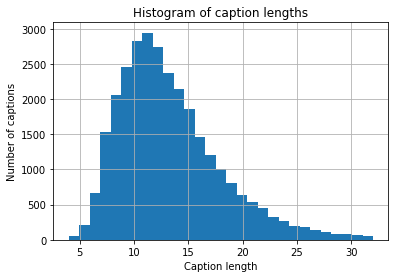

In [ ]:
print("Captions after filtering based on length:",len(caption_lengths))

n, bins, patches = plt.hist(caption_lengths, bins = (MAX_CAPTION_LEN - MIN_CAPTION_LEN + 1))
plt.xlabel('Caption length')
plt.ylabel('Number of captions')
plt.title('Histogram of caption lengths')
plt.grid(True)
plt.show()

<start>  A silver and red race car competes in a race while a crowd of people look on . <end>


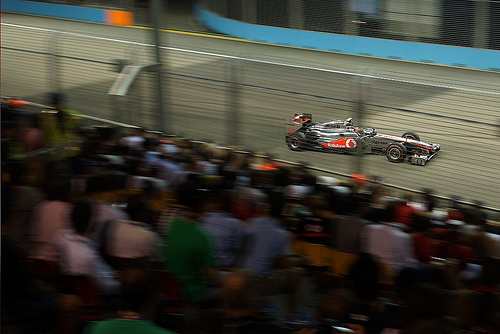

In [ ]:
print(train_captions[2])
Image.open(img_name_vector[2])

## Load image using InceptionV3

In [ ]:
def load_image_InceptionV3(image_path):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.keras.layers.Resizing(299, 299)(img)
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

## Load image using ResNet152V2

In [ ]:
def load_image_ResNet152v2(image_path):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.keras.layers.Resizing(224, 224)(img)
    img = tf.keras.applications.resnet_v2.preprocess_input(img)
    return img, image_path

## Preprocess using CNN

In [ ]:
if (CNN_USED == 'InceptionV3'):
  image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                  weights='imagenet')
else:
  image_model = tf.keras.applications.resnet_v2.ResNet152V2(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

87924736/87910968 [==============================] - 0s 0us/step


In [ ]:
# Get unique images
encode_train = sorted(set(img_name_vector))

# Feel free to change batch_size according to your system configuration
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
if (CNN_USED == 'InceptionV3'):
  image_dataset = image_dataset.map(load_image_InceptionV3, num_parallel_calls=tf.data.AUTOTUNE).batch(16)
else:
  image_dataset = image_dataset.map(load_image_ResNet152v2, num_parallel_calls=tf.data.AUTOTUNE).batch(16)

for img, path in tqdm(image_dataset):
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())

100%|██████████| 375/375 [01:11<00:00,  5.28it/s]


## Preprocess and tokenize the captions

In [ ]:
caption_dataset = tf.data.Dataset.from_tensor_slices(train_captions)

# We will override the default standardization of TextVectorization to preserve
# "<>" characters, so we preserve the tokens for the <start> and <end>.
def standardize(inputs):
  inputs = tf.strings.lower(inputs)
  return tf.strings.regex_replace(inputs,
                                  r"!\"#$%&\(\)\*\+.,-/:;=?@\[\\\]^_`{|}~", "")

# Max word count for a caption.
max_length = MAX_LENGTH 
# Use the top 10000 words for a vocabulary.
vocabulary_size = VOCABULARY_SIZE 
tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=vocabulary_size,
    standardize=standardize,
    output_sequence_length=max_length)
# Learn the vocabulary from the caption data.
tokenizer.adapt(caption_dataset)

In [ ]:
# Create the tokenized vectors
cap_vector = caption_dataset.map(lambda x: tokenizer(x))

In [ ]:
# Create mappings for words to indices and indicies to words.
word_to_index = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary())
index_to_word = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary(),
    invert=True)

## Split the data into training and testing

In [ ]:
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(img_name_vector, cap_vector):
  img_to_cap_vector[img].append(cap)

# Create training and validation sets using an 80-20 split randomly.
img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

slice_index = int(len(img_keys)*0.8)
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]

img_name_train = []
cap_train = []
for imgt in img_name_train_keys:
  capt_len = len(img_to_cap_vector[imgt])
  img_name_train.extend([imgt] * capt_len)
  cap_train.extend(img_to_cap_vector[imgt])

img_name_val = []
cap_val = []
for imgv in img_name_val_keys:
  capv_len = len(img_to_cap_vector[imgv])
  img_name_val.extend([imgv] * capv_len)
  cap_val.extend(img_to_cap_vector[imgv])

In [ ]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(23782, 23782, 5951, 5951)

## Create a tf.data dataset for training

In [ ]:
# Feel free to change these parameters according to your system's configuration

BATCH_SIZE = 64
BUFFER_SIZE = 1000
units = 512
num_steps = len(img_name_train) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# Shape of the vector extracted from ResNet152V2 is (49, 2048)
# These two variables represent that vector shape
features_shape = 2048
if (CNN_USED == 'InceptionV3'):
  attention_features_shape = 64
else:
  attention_features_shape = 49

In [ ]:
# Load the numpy files
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int64]),
          num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

## Pre-trained Embeddings

In [ ]:
if(PRETRAINED_EMBEDDINGS):
  !wget http://nlp.stanford.edu/data/glove.6B.zip
  !unzip -q glove.6B.zip

--2022-03-05 17:17:09--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-03-05 17:17:09--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-03-05 17:17:10--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [ ]:
if(PRETRAINED_EMBEDDINGS):
  path_to_glove_file = os.path.join(
      os.path.expanduser("~"), "/content/glove.6B." + str(EMBEDDING_DIM) + "d.txt"
  )

  embeddings_index = {}
  with open(path_to_glove_file) as f:
      for line in f:
          word, coefs = line.split(maxsplit=1)
          coefs = np.fromstring(coefs, "f", sep=" ")
          embeddings_index[word] = coefs

  print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [ ]:
if(PRETRAINED_EMBEDDINGS):
  num_tokens = VOCABULARY_SIZE + 2
  hits = 0
  misses = 0

  # Prepare embedding matrix
  embedding_matrix = np.zeros((num_tokens, EMBEDDING_DIM))
  words = tokenizer.get_vocabulary()
  for i,word in enumerate(words):
      embedding_vector = embeddings_index.get(word)
      if embedding_vector is not None:
          # Words not found in embedding index will be all-zeros.
          # This includes the representation for "padding" and "OOV"
          embedding_matrix[i] = embedding_vector
          hits += 1
      else:
          misses += 1
  print("Converted %d words (%d misses)" % (hits, misses))

Converted 4960 words (40 misses)


## Model

In [ ]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, EMBEDDING_DIM)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # attention_hidden_layer shape == (batch_size, 64, units)
    attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                         self.W2(hidden_with_time_axis)))

    # score shape == (batch_size, 64, 1)
    # This gives you an unnormalized score for each image feature.
    score = self.V(attention_hidden_layer)

    # attention_weights shape == (batch_size, 64, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [ ]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it
    # This encoder passes those features through a Fully connected layer
    def __init__(self, EMBEDDING_DIM):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, EMBEDDING_DIM)
        self.fc = tf.keras.layers.Dense(EMBEDDING_DIM)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [ ]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, EMBEDDING_DIM, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    if(not PRETRAINED_EMBEDDINGS):
      self.embedding = tf.keras.layers.Embedding(vocab_size, EMBEDDING_DIM)
    else:
      self.embedding = Embedding(
                        num_tokens,
                        EMBEDDING_DIM,
                        embeddings_initializer=keras.initializers.Constant(embedding_matrix),
                        trainable=False,
                    )

    if(DECODER_LAYER == 'GRU'): 
      self.decoder_layer = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    else:
      self.decoder_layer = tf.keras.layers.LSTM(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

    
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.dropout1 = tf.keras.layers.Dropout(DROPOUT_VALUE_1)
    self.dropout2 = tf.keras.layers.Dropout(DROPOUT_VALUE_2)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, EMBEDDING_DIM)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, EMBEDDING_DIM + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU/LSTM
    if(DECODER_LAYER == 'GRU'): 
      output, state = self.decoder_layer(x)
    else:
      output, state, carry_state = self.decoder_layer(x)
      # final_memory_state, final_carry_state

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    if (DROPOUT_AFTER_FC1):
      x = self.dropout1(x)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    if (DROPOUT_AFTER_FC2):
      x = self.dropout2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [ ]:
encoder = CNN_Encoder(EMBEDDING_DIM)
decoder = RNN_Decoder(EMBEDDING_DIM, units, tokenizer.vocabulary_size())

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')


def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

## Checkpoint

In [ ]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [ ]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

## Training

In [ ]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

In [ ]:
@tf.function
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([word_to_index('<start>')] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [ ]:
for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            average_batch_loss = batch_loss.numpy()/int(target.shape[1])
            print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save()

    print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

Epoch 1 Batch 0 Loss 2.4027
Epoch 1 Batch 100 Loss 1.1578
Epoch 1 Batch 200 Loss 1.1998
Epoch 1 Batch 300 Loss 1.0708
Epoch 1 Loss 1.193342
Time taken for 1 epoch 162.93 sec

Epoch 2 Batch 0 Loss 1.0651
Epoch 2 Batch 100 Loss 1.0167
Epoch 2 Batch 200 Loss 0.9751
Epoch 2 Batch 300 Loss 0.9265
Epoch 2 Loss 0.968044
Time taken for 1 epoch 81.92 sec

Epoch 3 Batch 0 Loss 0.9967
Epoch 3 Batch 100 Loss 0.8959
Epoch 3 Batch 200 Loss 0.8884
Epoch 3 Batch 300 Loss 0.8154
Epoch 3 Loss 0.884778
Time taken for 1 epoch 68.79 sec

Epoch 4 Batch 0 Loss 0.8262
Epoch 4 Batch 100 Loss 0.8360
Epoch 4 Batch 200 Loss 0.8570
Epoch 4 Batch 300 Loss 0.7482
Epoch 4 Loss 0.824729
Time taken for 1 epoch 68.87 sec

Epoch 5 Batch 0 Loss 0.8051
Epoch 5 Batch 100 Loss 0.6583
Epoch 5 Batch 200 Loss 0.7365
Epoch 5 Batch 300 Loss 0.6553
Epoch 5 Loss 0.773742
Time taken for 1 epoch 69.07 sec

Epoch 6 Batch 0 Loss 0.8166
Epoch 6 Batch 100 Loss 0.7126
Epoch 6 Batch 200 Loss 0.6413
Epoch 6 Batch 300 Loss 0.7703
Epoch 6 Los

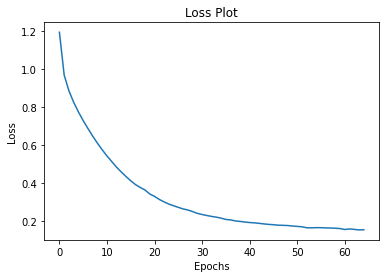

In [ ]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

## Caption

In [ ]:
def evaluate_categorical(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)
    if (CNN_USED == 'InceptionV3'):
      temp_input = tf.expand_dims(load_image_InceptionV3(image)[0], 0)
    else:
      temp_input = tf.expand_dims(load_image_ResNet152v2(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0],
                                                 -1,
                                                 img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([word_to_index('<start>')], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input,
                                                         features,
                                                         hidden)
        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        predicted_word = tf.compat.as_text(index_to_word(predicted_id).numpy())
        result.append(predicted_word)

        if predicted_word == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [ ]:
def evaluate_beamSearch(image, beam_index = BEAM_WIDTH):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    if (CNN_USED == 'InceptionV3'):
      temp_input = tf.expand_dims(load_image_InceptionV3(image)[0], 0)
    else:
      temp_input = tf.expand_dims(load_image_ResNet152v2(image)[0], 0)
    
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0],
                                                 -1,
                                                 img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([word_to_index('<start>')], 0)
    result = []
    
    start = [word_to_index("<start>")]
    
    predicted_ids = [[start, 0.0]]
    
    for i in range(max_length):
        temp=[]
        for s in predicted_ids:
            dec_input = tf.expand_dims([s[0][-1]], 0)
            predictions, hidden, attention_weights = decoder(dec_input,
                                                         features,
                                                         hidden)
        
            attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

            predictions = tf.nn.softmax(predictions)
        
            word_preds = np.argsort(predictions[0])[-beam_index:]
            for w in word_preds:
                    next_cap, prob = s[0][:], s[1]
                    next_cap.append(w)
                    prob += predictions[0][w]
                    temp.append([next_cap, prob])
             
            
        predicted_ids = temp
        predicted_ids = sorted(predicted_ids, reverse=False, key=lambda l: l[1])
        
        predicted_ids = predicted_ids[-beam_index:]
        if tf.compat.as_text(index_to_word(predicted_ids[0][0][-1]).numpy()) == '<end>' and tf.compat.as_text(index_to_word(predicted_ids[1][0][-1]).numpy()) == '<end>' and tf.compat.as_text(index_to_word(predicted_ids[2][0][-1]).numpy()) == '<end>':
            break
        
        
        
    pred_id = predicted_ids[-1][0]
    for j in pred_id[1:]:
        pred_word = tf.compat.as_text(index_to_word(j).numpy())
        if pred_word != '<end>':
            result.append(pred_word)
        else:
            break

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [ ]:
def evaluate(image):
  if SENTENCE_GENERATOR_METHOD == 'CATEGORICAL':
    return evaluate_categorical(image)
  else:
    return evaluate_beamSearch(image)

## Ετοιμασία αρχείου answer.txt

In [ ]:
test_hypotheses = []
for [img] in test_img_paths:
  img_path = '/content/image_dir/' + img
  result, attention_plot = evaluate(img_path)
  test_hypotheses.append(result)

In [ ]:
import json 

jsonString = json.dumps(test_hypotheses)
jsonFile = open("test_hypotheses.json", "w")
jsonFile.write(jsonString)
jsonFile.close()